1️⃣ Встановлення бібліотек

Якщо при запуску з’являється помилка типу ModuleNotFoundError, це означає, що потрібна бібліотека не встановлена.
Щоб встановити потрібні пакети, можна використовувати pip:


командному рядку або терміналі по черзі введіть ці команди по одній і натискайте Enter:

pip install numpy
pip install matplotlib
pip install xarray
pip install cartopy
pip install geopandas

або те чого не вистачає 

In [2]:
# =========================================================
# Імпорт необхідних бібліотек
# =========================================================
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr

# Бібліотеки для картографії
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Робота з векторними геоданими (shapefile)
import geopandas as gpd



Встановлення дати:
У коді є змінна, в яку потрібно вписати потрібну дату у форматі YYYYMMDD_HHMMz.
Це єдине місце, яке потрібно змінювати для запуску карти на різні дати.

Файли GEOS-Chem:
Програма автоматично формує шляхи до двох файлів GEOS-Chem (SpeciesConc і StateMet) з урахуванням дати, яку ви задали.
Не потрібно змінювати назви файлів або шляхи вручну — лише переконайтесь, що файли з цією датою дійсно існують у папці.

In [3]:
# =========================================================
# Встановлюємо дату моделювання (використовується у назвах файлів)
# =================================================
date = "20231031_0000z"
# Можливі інші дати:
# ['20250225_0000z', '20240415_0000z', '20240328_0000z',
#  '20250310_0000z', '20240210_0000z']

# =========================================================
# Формуємо шляхи до файлів GEOS-Chem за допомогою f-рядків
# =========================================================
species_file = f"/Users/julia/GEOS chem/geos-chem dust events/GEOSChem.SpeciesConc.{date}.nc4"
statemet_file = f"/Users/julia/GEOS chem/geos-chem dust events/GEOSChem.StateMet.{date}.nc4"

# =========================================================
# Відкриваємо файл з концентраціями хімічних видів
# =========================================================
ds_species = xr.open_dataset(species_file)

# Список змінних, що відповідають різним бінів пилу (DST1–DST4)
dust_vars = [
    'SpeciesConcVV_DST1',
    'SpeciesConcVV_DST2',
    'SpeciesConcVV_DST3',
    'SpeciesConcVV_DST4'
]

# =========================================================
# Обчислюємо сумарну концентрацію пилу
# беремо:
#  - перший часовий крок (time = 0)
#  - приземний рівень (lev = 0)
# =========================================================
dust = sum(ds_species[var].isel(time=0, lev=0) for var in dust_vars)

# Координати довготи та широти (можуть знадобитися для побудови карт)
lon = ds_species['lon']
lat = ds_species['lat']

# =========================================================
# Відкриваємо файл StateMet з метеорологічними змінними
# =========================================================
ds_state = xr.open_dataset(statemet_file)

# Густина повітря (перший час, приземний рівень)
airden = ds_state['Met_AIRDEN'].isel(time=0, lev=0)

# =========================================================
# Молекулярні маси
# =========================================================
M_dust = 29.0     # молекулярна маса пилу, г/моль
M_air = 28.97     # молекулярна маса повітря, г/моль

# =========================================================
# Обчислення масової концентрації пилу в g/m³
# SpeciesConcVV — це об’ємне співвідношення (mol/mol),
# тому множимо на густину повітря та враховуємо молекулярні маси
# =========================================================
dust_diag = dust * airden * 1000 * (M_dust / M_air)

# =========================================================
# Перетворення з g/m³ у µg/m³
# =========================================================
dust_diag = dust_diag * 1e6

# Для перевірки результату можна роздрукувати масив
# print(dust_diag)


Файл з кордонами країн (countries_file)

Це Shapefile, який містить полігони країн.

Потрібно вказати повний шлях до файлу на вашому комп’ютері.

Наприклад, якщо файл лежить у папці data, шлях буде щось на кшталт:
"/Users/username/data/ne_110m_admin_0_countries.shp"

Не змінюйте назву файлу, якщо він вже є, або вкажіть відповідний свій файл з кордонами.

Файл з містами (cities_file)

Це Shapefile, який містить точки міст.

Вкажіть повний шлях до вашого файлу з містами.

Можна використовувати той же файл, що і в прикладі, або інший, якщо він точніше відображає міста, які потрібні на карті.

Папка для збереження карт (output_folder)

Вкажіть папку, куди будуть зберігатися згенеровані PNG-карти.

Папка повинна існувати на диску, або створіть її заздалегідь.

Наприклад:
"/Users/username/GEOS-chem/output_maps"

Файл буде автоматично зберігатися з іменем, яке включає дату моделі.

In [51]:
# =========================================================
#  ПІДГОТОВКА КОЛЬОРОВОЇ ШКАЛИ ТА ШЛЯХІВ ДО ФАЙЛІВ
# =========================================================

# Функція для освітлення стандартної кольорової карти matplotlib
# Потрібна для того, щоб карта була менш контрастною
# і краще читалися написи поверх неї
def lighten_cmap(cmap_name, factor=0.3):
    base_cmap = plt.get_cmap(cmap_name)           # базова палітра
    colors = base_cmap(np.linspace(0, 1, 256))    # дискретизація палітри
    white = np.ones((256, 4))                      # масив білого кольору
    new_colors = colors * factor + white * (1 - factor)  # змішування
    return mcolors.ListedColormap(new_colors)      # нова палітра

# Освітлена палітра для відображення пилу
light = lighten_cmap("Spectral_r", factor=0.85)

# Shapefile з кордонами країн
countries_file = "ne_110m_admin_0_countries.shp"  # вкажи свій шлях

# Shapefile з містами
cities_file = "ne_10m_populated_places.shp"       # або інший shapefile міст

# Папка, куди зберігатимуться згенеровані зображення
output_folder = "/Users/julia/GEOS chem/geos-chem dust events/output_folder"


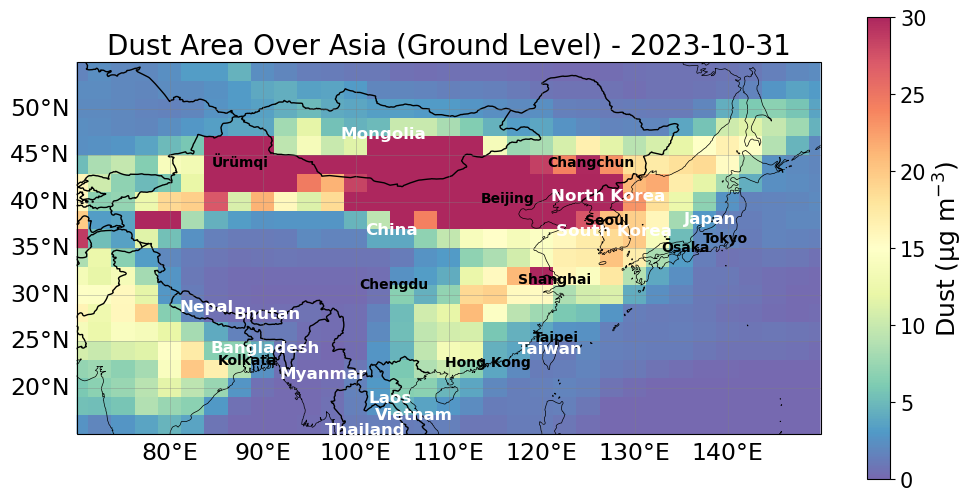

In [57]:
# =========================================================
# ПОБУДОВА КАРТИ ТА ВІЗУАЛІЗАЦІЯ ДАНИХ
# =========================================================

# Створення фігури з географічною проекцією PlateCarree
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Основний графік: концентрація пилу на приземному рівні
pcm = ax.pcolormesh(
    lon, lat, dust_diag,
    cmap=light,
    vmin=0, vmax=30,                  # фіксовані межі шкали (як у тебе)
    transform=ccrs.PlateCarree()
)

# Кольорова шкала
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label(r'Dust (μg m$^{-3}$)', fontsize=18)
cbar.ax.tick_params(labelsize=15)

# Додавання кордонів країн та узбережжя
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Обмеження області карти (Азія)
ax.set_extent([70, 150, 15, 55], crs=ccrs.PlateCarree())

# =========================================================
# ПІДПИСИ, СІТКА, ЗАГОЛОВОК І ЗБЕРЕЖЕННЯ
# =========================================================

# --- Підписи країн ---
countries = gpd.read_file(countries_file)
for idx, row in countries.iterrows():
    centroid = row['geometry'].centroid
    if 80 <= centroid.x <= 150 and 15 <= centroid.y <= 55:
        ax.text(
            centroid.x, centroid.y, row['ADMIN'],
            fontsize=12, fontweight='bold', color='white',
            transform=ccrs.PlateCarree(),
            ha='center'
        )

# --- Підписи міст ---
cities = gpd.read_file(cities_file)
major_cities = cities[
    (cities['SCALERANK'] <= 1) |
    (cities['NAME'].isin(['Beijing', 'Changchun']))
]

for idx, city in major_cities.iterrows():
    if 80 <= city.geometry.x <= 150 and 15 <= city.geometry.y <= 55:
        ax.text(
            city.geometry.x, city.geometry.y, city['NAME'],
            fontsize=10, fontweight='bold',
            ha='center', color='black',
            transform=ccrs.Geodetic()
        )

# Сітка координат і підписи осей
gl = ax.gridlines(draw_labels=True, linewidth=0.5,
                  color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'fontsize': 17}
gl.ylabel_style = {'fontsize': 17}

# Формування заголовка з датою з імені файлу GEOS-Chem
file_path = species_file
date_str = os.path.basename(file_path).split('.')[2].split('_')[0]
formatted_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"

ax.set_title(
    f'Dust Area Over Asia (Ground Level) - {formatted_date}',
    fontsize=20
)

# Збереження та відображення фігури
save_path = os.path.join(output_folder, f"dust_map_{date_str}.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

